In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn')

import data_io # Custom IO file

# Input/Output of RGA and Temperature Data

In [4]:
p = os.getcwd() + "/data/2020_11_09/RGA/" # data file path

In [5]:
data = data_io.read_rga_outs(p)

In [6]:
#data.to_hdf(p+"10_19_rga_2020.h5", key='data')

In [7]:
data

,Datetime,Mass_amu,Partial_Pressure_torr
0,2020-11-09 16:59:53,1,1.93e-09
1,2020-11-09 16:59:53,1.1,3.31e-09
2,2020-11-09 16:59:53,1.2,6.48e-08
3,2020-11-09 16:59:53,1.3,2.31e-07
4,2020-11-09 16:59:53,1.4,4.75e-08
...,...,...,...
986,2020-11-12 00:59:28,99.6,-1.68e-10
987,2020-11-12 00:59:28,99.7,-1.09e-10
988,2020-11-12 00:59:28,99.8,-9.69e-11
989,2020-11-12 00:59:28,99.9,-9.48e-11


In [8]:
times = data['Datetime'].unique()

In [9]:
H2_pressure = data[data['Mass_amu'] == 2.0]['Partial_Pressure_torr']
H2O_pressure = data[data['Mass_amu'] == 18.0]['Partial_Pressure_torr']
N2_pressure = data[data['Mass_amu'] == 28.0]['Partial_Pressure_torr']
O2_pressure = data[data['Mass_amu'] == 32.0]['Partial_Pressure_torr']
CO2_pressure = data[data['Mass_amu'] == 44.0]['Partial_Pressure_torr']

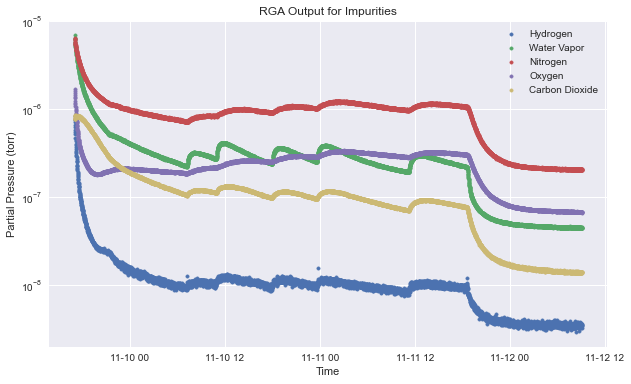

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(times, H2_pressure, marker='.', label='Hydrogen')
ax.scatter(times, H2O_pressure, marker='.', label='Water Vapor')
ax.scatter(times, N2_pressure, marker='.', label='Nitrogen')
ax.scatter(times, O2_pressure, marker='.', label='Oxygen')
ax.scatter(times, CO2_pressure, marker='.', label='Carbon Dioxide')
ax.set_title('RGA Output for Impurities')
ax.set_xlabel('Time')
ax.set_ylabel('Partial Pressure (torr)')
plt.yscale('log')
ax.legend()
plt.savefig('rga_out_2020_11_09.png', dpi=300)
plt.show()